In [1]:
from transporter_env import TransportEnv, MAT, OneDynamicTransporter
import matplotlib.pyplot as plt


# env = MAT(max_capacity=10)#size=12, transporters_hubs=(27, 116), horizon=128)
env = OneDynamicTransporter()

/opt/homebrew/lib/python3.10/site-packages/gymnasium/spaces/box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


transporter 1 total profit 2.2666666666666586


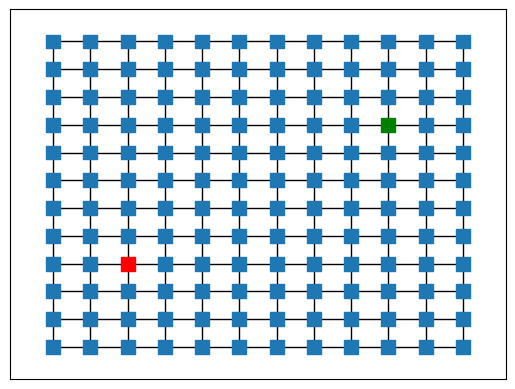

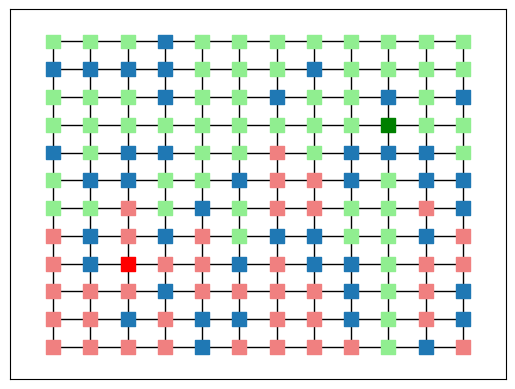

In [2]:
rewards = []
env.reset()
env.render()
done = False
while not done:
    action = 1
    _, r, d, *_ = env.step(action)
    done = d
    rewards.append(r)
env.render()
t1_r = [r for r in rewards]
# t2_r = [r[1] for r in rewards]
print('transporter 1 total profit', sum(t1_r))
# print('transporter 2 total profit', sum(t2_r))

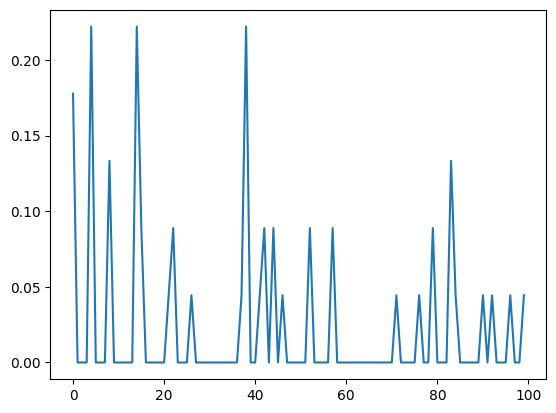

In [3]:
plt.plot(rewards)

## DQN

### Preliminaries

In [4]:
import torch
from transporter_env import TransportEnv, MAT, OneDynamicTransporter


import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from rlberry.agents import Agent
from rlberry.manager import AgentManager, plot_writer_data

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

# torch device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(torch.backends.mps.is_built())
print(device)

True
mps


In [5]:
from rlberry.agents import Agent

class MyAgent(Agent):
  name = "MyAgent"
  def __init__(self, env, param1, param2, **kwargs):
    """
    The base class (Agent) initializes:
      self.env : instance of the environment used for training (in fit() method)
      self.eval_env : instance of the environment used for evaluation (in eval() method)
      self.rng : random number generator (https://numpy.org/doc/stable/reference/random/generator.html)
      self.writer : use self.writer.add_scalar(tag, value, global_step) to log training data
    
    For reproducibility, use ONLY self.rng if you need random numbers in you agent!
    To be able to visualize plots with AgentManager, log data using self.writer (see below)
    """
    Agent.__init__(self, env, **kwargs)
    self.param1 = param1
    self.param2 = param2
    self.total_steps = 0
    self.total_episodes = 0

  def select_action(self, state, evaluation=False):
    """
    If evaluation=True, run evaluation policy (e.g., greedy with respect to Q)
    If evaluation=False, run exploration policy (e.g., epsilon greedy)
    """
    return self.env.action_space.sample()  # random action for this example

  def fit(self, budget):
    """budget = number of timesteps to train your agent"""
    state, _ = self.env.reset()
    episode_reward = 0.0
    for tt in range(budget):
      self.total_steps += 1
      action = self.select_action(state, evaluation=False)
      next_state, reward, done, *_ = self.env.step(action)
      episode_reward += reward
      # print(reward)

      # Log data
      self.writer.add_scalar('rewards', reward, global_step=self.total_steps)

      state = next_state 
      if done:
        self.total_episodes += 1
        # Log episode data
        self.writer.add_scalar('episode_rewards', episode_reward, global_step=self.total_steps)
        self.writer.add_scalar('episode', self.total_episodes, global_step=self.total_steps)

        state, _ = self.env.reset()
        episode_reward = 0.0
        
  
  def eval(self, **kwargs):
    """
    Here, you can run Monte-Carlo policy evaluation 
    with self.eval_env and return the result.
    Returning zero for this example.
    """
    return 0.0

In [6]:
#
# Initialize and train a single instance of MyAgent
#
my_agent = MyAgent(
    env=(OneDynamicTransporter, {}),       # tuple (constructor, kwargs)
    param1=10,               # extra params your agent might need
    param2=15)
# train the agent for 100 timesteps
my_agent.fit(100)
# pandas DataFrame containing data stored with my_agent.writer.add_scalar(tag, value, global_step)
print(my_agent.writer.data)

#
# Run several instances of MyAgent in parallel and plot the results
#
manager_kwargs = dict(
    agent_class=MyAgent,
    train_env=(OneDynamicTransporter, dict()),
    eval_env=(OneDynamicTransporter, dict()),
    fit_budget=100,                    # Number of total timesteps
    n_fit=2,                           # Number of agent instances to fit
    parallelization='thread',          # Use 'thread' in the notebook!
    seed=456,                          # Seed
    default_writer_kwargs=dict(maxlen=None,log_interval=10),
)
my_agent_manager = AgentManager(
    init_kwargs=dict(param1=10, param2=20),
    agent_name='MyAgent',
    **manager_kwargs
)
my_agent_manager.fit()   # Train 'n_fit' instances in parallel

/opt/homebrew/lib/python3.10/site-packages/gymnasium/spaces/box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
[WARNING] 13:31: (Re)defining the following DefaultWriter parameters in AgentManager: ['maxlen', 'log_interval'] 
[INFO] 13:31: Running AgentManager fit() for MyAgent with n_fit = 2 and max_workers = None. 


        name              tag      value global_step  dw_time_elapsed
0    MyAgent          rewards   3.111111           1         0.001249
1    MyAgent          rewards   0.000000           2         0.001976
2    MyAgent          rewards   3.511111           3         0.002685
3    MyAgent          rewards   0.866667           4         0.003403
4    MyAgent          rewards  -1.000000           5         0.004139
..       ...              ...        ...         ...              ...
97   MyAgent          rewards   0.000000          98         0.256224
98   MyAgent          rewards   0.000000          99         0.259756
99   MyAgent          rewards   0.000000         100         0.262554
100  MyAgent  episode_rewards  32.000000         100         0.262560
101  MyAgent          episode   1.000000         100         0.262563

[102 rows x 5 columns]


/opt/homebrew/lib/python3.10/site-packages/gymnasium/spaces/box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
[INFO] 13:31: ... trained! 
/opt/homebrew/lib/python3.10/site-packages/gymnasium/spaces/box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [7]:
from gymnasium.wrappers import RecordVideo
%mkdir videos
# Initialize display and import function to show videos

def render_policy(env, agent):
  env = deepcopy(env)
  # env = RecordVideo(env, './videos')
  for episode in range(1):
    done = False
    state, _ = env.reset()
    env.render()
    while not done:
        action = agent.select_action(state, evaluation=True)
        state, reward, done, *_ = env.step(action)
    env.render()
    env.close()
    


mkdir: videos: File exists


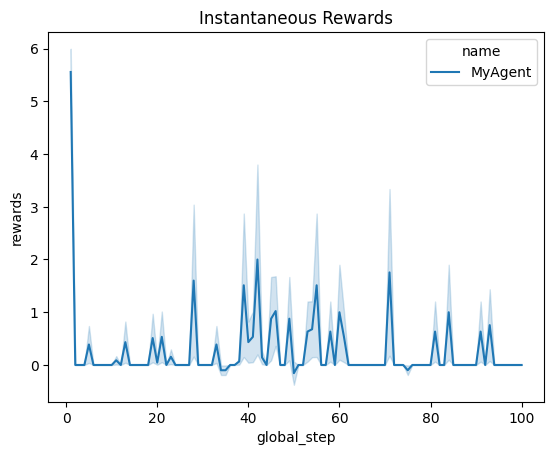

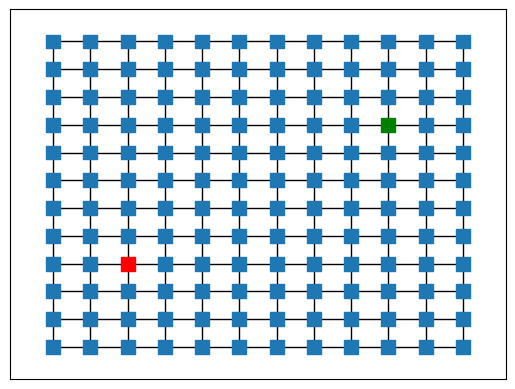

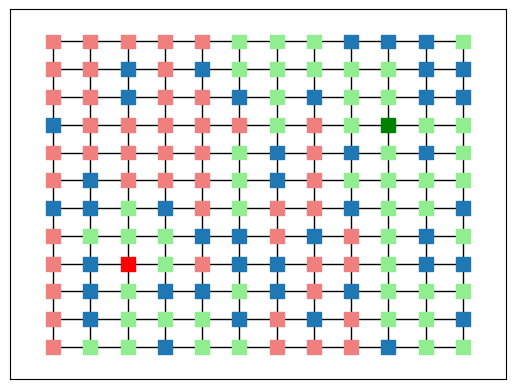

In [8]:
# Plot the results
example_managers = []
example_managers.append(my_agent_manager)    # You could add more managers here, for other agents/parameters
_ = plot_writer_data(example_managers, tag='rewards', title='Instantaneous Rewards')
# _ = plot_writer_data(example_managers, tag='episode_rewards', xtag='episode', title='Episode Rewards')
# _ = plot_writer_data(example_managers, tag='episode_rewards', xtag='episode', title='Cumulative Episode Rewards', preprocess_func=np.cumsum)

# Render the policy of one of the trained agents
agent_instance = my_agent_manager.get_agent_instances()[0]
render_policy(agent_instance.eval_env, agent_instance)

In [9]:
class ReplayBuffer:
  def __init__(self, capacity, rng):
    """
    Parameters
    ----------
    capacity : int
      Maximum number of transitions
    rng : 
      instance of numpy's default_rng
    """
    self.capacity = capacity
    self.rng = rng  # random number generator
    self.memory = []
    self.position = 0

  def push(self, sample):
    """Saves a transition."""
    if len(self.memory) < self.capacity:
      self.memory.append(None)
    self.memory[self.position] = sample
    self.position = (self.position + 1) % self.capacity

  def sample(self, batch_size):
    indices = self.rng.choice(len(self.memory), size=batch_size)
    samples = [self.memory[idx] for idx in indices]
    return map(np.asarray, zip(*samples))

  def __len__(self):
    return len(self.memory)

In [10]:
class QNet(nn.Module):
  def __init__(self, obs_size, n_actions):
    super(QNet, self).__init__()
    
    #print(f'obs size = {obs_size}')
    self.lin1 = nn.Linear(obs_size, 64)
    self.lin2 = nn.Linear(64, 64)
    self.lin3 = nn.Linear(64, n_actions)
    #self.relu = nn.ReLU().to(device)

  def forward(self, state):

    if not isinstance(state, torch.Tensor):
      state = torch.tensor(state).float().to(device)
    #else :
    #  state = state.clone().detach().float().to(device)
    
    Q = F.relu(self.lin1(state))
    Q = F.relu(self.lin2(Q))
    return self.lin3(Q)

class DuelingQNet(nn.Module):
  def __init__(self, obs_size, n_actions):
    super(DuelingQNet, self).__init__()

    self.relu = nn.ReLU()
    self.lin = nn.Linear(obs_size, 64)

    # value function net
    self.val_lin1 = nn.Linear(64, 64)
    self.val_lin2 = nn.Linear(64, 1)

    # advantage function net
    self.adv_lin1 = nn.Linear(64, 64)
    self.adv_lin2 = nn.Linear(64, n_actions)

  def forward(self, state):

    if not isinstance(state, torch.Tensor):
      state = torch.tensor(state).float().to(device)
    #else :
      #state = state.clone().detach().float().to(device)

    y = self.lin(state)
    y = self.relu(y)

    # value function
    v = self.val_lin1(y)
    v = self.relu(v)
    v = self.val_lin2(v)

    # advantage function
    a = self.adv_lin1(y)
    a = self.relu(a)
    a = self.adv_lin2(a)

    return v + (a - torch.mean(a))
  
class LSTMQNet(nn.Module):
  def __init__(self, obs_size, n_actions):
    super(DuelingQNet, self).__init__()

    self.relu = nn.ReLU()
    self.lstm = nn.LSTM(obs_size, 64)

    self.lin1 = nn.Linear(64, 64)
    self.lin2 = nn.Linear(64, n_actions)

  def forward(self, state):

    if not isinstance(state, torch.Tensor):
      state = torch.tensor(state).float().to(device)
    #else :
      #state = state.clone().detach().float().to(device)

    y = self.lstm(state)
    y = self.relu(y)

    # value function
    v = self.lin1(y)
    v = self.relu(v)
    return self.lin2(v)

In [11]:
# Parameters
DQN_TRAINING_TIMESTEPS = 1000  # number of timesteps for training. You might change this!

DQN_PARAMS = dict(
    dueling_dqn=False,         # set to true to use dueling DQN
    double_dqn=False,          # set to true to use double DQN
    gamma=0.99,
    batch_size=128,            # batch size (in number of transitions)
    eval_every=250,            # evaluate every ... steps
    buffer_capacity=30000,     # capacity of the replay buffer
    update_target_every=250,   # update target net every ... steps
    epsilon_start=1.0,         # initial value of epsilon
    epsilon_min=0.05,          # minimum value of epsilon
    decrease_epsilon=5000,     # parameter to decrease epsilon
    learning_rate=5e-4,       # learning rate
)
DUELING_DQN_PARAMS = deepcopy(DQN_PARAMS)           # dueling DQN
DOUBLE_DQN_PARAMS = deepcopy(DQN_PARAMS)            # double DQN
DOUBLE_DUELING_DQN_PARAMS = deepcopy(DQN_PARAMS)    # double & dueling DQN
# LSTM_DQN_PARAMS = deepcopy(DQN_PARAMS)

DUELING_DQN_PARAMS.update(dict(dueling_dqn=True))
DOUBLE_DQN_PARAMS.update(dict(double_dqn=True))
DOUBLE_DUELING_DQN_PARAMS.update(dueling_dqn=True, double_dqn=True)
# LSTM_DQN_PARAMS.update(dict(rnn = False))



In [12]:
class DQNAgent(Agent):
  name = 'DQN'
  def __init__(
      self,
      env,
      dueling_dqn: bool,               # Set to true for dueling DQN
      double_dqn: bool,                # Set to true for double DQN
      gamma: float = 0.99,
      batch_size: int = 256,
      eval_every: int = 250,
      buffer_capacity: int = 30000,
      update_target_every: int = 500,
      epsilon_start: float = 1.0,
      epsilon_min: float = 0.05,
      decrease_epsilon: int = 200,
      learning_rate: float = 0.001,
      **kwargs):
    Agent.__init__(self, env, **kwargs)
    env = self.env
    self.dueling_dqn = dueling_dqn
    self.double_dqn = double_dqn
    self.gamma = gamma
    self.batch_size = batch_size
    self.eval_every = eval_every
    self.update_target_every = update_target_every
    self.epsilon_start = epsilon_start
    self.epsilon_min = epsilon_min
    self.decrease_epsilon = decrease_epsilon
    self.total_timesteps = 0
    self.total_episodes = 0
    self.total_updates = 0

    # initialize epsilon
    self.epsilon = epsilon_start

    # initialize replay buffer
    self.replay_buffer = ReplayBuffer(buffer_capacity, self.rng)

    # select network class
    if self.dueling_dqn:
      net_class = DuelingQNet
    else:
      net_class = QNet
      
    # if self.rnn:
      # net_class = LSTMQNet

    # update name according to params
    if self.dueling_dqn:
      self.name = 'Dueling' + self.name
    if self.double_dqn:
      self.name = 'Double' + self.name

    # create network and target network
    obs_size = env.observation_space.shape[0]
    n_actions = env.action_space.n
    self.q_net = net_class(obs_size, n_actions).to(device)
    self.target_net = net_class(obs_size, n_actions).to(device)
    self.target_net.load_state_dict(self.q_net.state_dict())
    self.target_net.eval()
    
    # objective and optimizer
    self.optimizer = optim.Adam(
        params=self.q_net.parameters(), lr=learning_rate)
    self.loss_fn = nn.MSELoss()

  def select_action(self, state, evaluation=False):
    """
    If evaluation=False, get action according to exploration policy.
    Otherwise, get action according to the evaluation policy.
    """
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # TODO: implement action selection strategy
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

    #print(f'random action = {self.env.action_space.sample()}')
    
    if self.rng.uniform() < self.epsilon and (not evaluation):
      action = self.env.action_space.sample()   # this happens with probability epsilon
    else:
      with torch.no_grad():
        action = torch.argmax(self.q_net(state)).item()

    return action # replace by the action you computed
  
  #@torch.compile
  def _update(self, batch_state, batch_action, batch_next_state, batch_reward):
    # values = Q(s_t, a_t), for t in batch
        values = self.q_net(batch_state).gather(1, batch_action.long())

        if not self.double_dqn:
          # !!!!!!!!!!!!!!!!!!!!!!!!!!
          # TO DO: compute DQN targets
          # !!!!!!!!!!!!!!!!!!!!!!!!!!

          with torch.no_grad():
            #next_state_values = torch.zeros(self.batch_size, device=device)
            next_state_values = self.target_net(batch_next_state).max(1)[0].unsqueeze(1).to(device)
            targets = (next_state_values * self.gamma) + batch_reward
      
        else:
          # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
          # TO DO: compute Double DQN targets
          # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

          with torch.no_grad():
            next_state_values = self.target_net(batch_next_state).gather(1, torch.argmax(self.q_net(batch_next_state), dim=1).unsqueeze(1)).to(device)
            targets = (next_state_values * self.gamma) + batch_reward


        loss = self.loss_fn(values, targets)#.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        #for param in self.q_net.parameters():
        #  param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        
        return loss

  def fit(self, budget):
    """
    budget : number of training timesteps
    """
    state, _ = self.env.reset()
    done = False
    episode_reward = 0.0
    for tt in range(budget):
      self.total_timesteps += 1
      # if self.env.t < 15:
      #   action = 0
      # else:
      action = self.select_action(state, evaluation=False)
      next_state, reward, done, *_ = self.env.step(action)
      episode_reward += reward
      # if not done :
      self.replay_buffer.push((state, next_state, action, reward, done))
      # else :
        # self.replay_buffer.push((state, next_state, action, -reward, done))
        
      if len(self.replay_buffer) > self.batch_size:
        #
        # Update model
        #
        self.total_updates += 1

        # get batch
        (batch_state, batch_next_state,
         batch_action, batch_reward,
         batch_done) = self.replay_buffer.sample(self.batch_size)
        # convert to torch tensors
        batch_state = torch.FloatTensor(batch_state).to(device)
        batch_next_state = torch.FloatTensor(batch_next_state).to(device)
        batch_action = torch.LongTensor(batch_action).unsqueeze(1).to(device)
        batch_reward = torch.FloatTensor(batch_reward).unsqueeze(1).to(device)
        batch_done = torch.FloatTensor(batch_done).unsqueeze(1).to(device)

        # decrease epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon -= (self.epsilon_start 
                             - self.epsilon_min) / self.decrease_epsilon

        #
        #  TO DO: compute loss and update networks
        #
        loss = self._update(batch_state, batch_action, batch_next_state, batch_reward)
        

        self.writer.add_scalar('loss', loss.item(), self.total_timesteps)

      # evaluate agent
      if self.total_timesteps % self.eval_every == 0:
          mean_rewards = self.eval(n_sim=2)
          self.writer.add_scalar(
              'eval_rewards', mean_rewards, self.total_timesteps)
      
      # update target network
      if self.total_updates % self.update_target_every == 0:
          self.target_net.load_state_dict(self.q_net.state_dict())
          self.target_net.eval()

      # check end of episode
      state = next_state
      if done:
        state, _ = self.env.reset()
        self.total_episodes += 1
        self.writer.add_scalar(
                'episode_rewards', episode_reward, self.total_timesteps)
        self.writer.add_scalar(
                'episode', self.total_episodes, self.total_timesteps)
        episode_reward = 0.0

  def eval(self, n_sim=1, **kwargs):
    rewards = np.zeros(n_sim)
    eval_env = self.eval_env     # evaluation environment
    # Loop over number of simulations
    for sim in range(n_sim):
      state, _ = eval_env.reset()
      done = False
      while not done:
        action = self.select_action(state, evaluation=True)
        #print(f'action = {type(action)}')
        next_state, reward, done, *_ = eval_env.step(action)
        # update sum of rewards
        rewards[sim] += reward
        state = next_state
    return rewards.mean()

In [13]:
# # Training one instance of DQN
# dqn_agent = DQNAgent(
#     env=(get_env, dict()),  # we can send (constructor, kwargs) as an env
#     **DQN_PARAMS
# )
# dqn_agent.fit(DQN_TRAINING_TIMESTEPS)

#
# Training several instances using AgentManager
#
def make_env():
    import gymnasium as gym
    e = gym.make('CartPole-v1')
    e.t = 16
    return e
    
manager_kwargs = dict(
    agent_class=DQNAgent,
    train_env=(OneDynamicTransporter, dict()),
    eval_env=(OneDynamicTransporter, dict()),
    fit_budget=DQN_TRAINING_TIMESTEPS,
    n_fit=4,                   # NOTE: You may increase this parameter (number of agents to train)
    parallelization='thread',
    seed=456,
    default_writer_kwargs=dict(maxlen=None,log_interval=10),
)

In [14]:
# DQN
dqn_manager = AgentManager(
    init_kwargs=DUELING_DQN_PARAMS,
    agent_name='DQN',
    **manager_kwargs
)
dqn_manager.fit()

[WARNING] 13:31: (Re)defining the following DefaultWriter parameters in AgentManager: ['maxlen', 'log_interval'] 
[INFO] 13:31: Running AgentManager fit() for DQN with n_fit = 4 and max_workers = None. 
/opt/homebrew/lib/python3.10/site-packages/gymnasium/spaces/box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
[INFO] 13:31: [DQN[worker: 1]] | max_global_step = 184 | episode_rewards = 51.644444444444446 | episode = 1 | loss = 2.3517212867736816 |  
[INFO] 13:31: [DQN[worker: 0]] | max_global_step = 185 | episode_rewards = 9.066666666666666 | episode = 1 | loss = 2.327569007873535 |  
[INFO] 13:31: [DQN[worker: 2]] | max_global_step = 183 | episode_rewards = 16.733333333333327 | episode = 1 | loss = 3.1874938011169434 |  
[INFO] 13:31: [DQN[worker: 3]] | max_global_step = 186 | episode_rewards = 39.46666666666667 | episode = 1 | loss = 3.7822787761688232 |  
[INFO] 13:32: [DQN[wor

In [ ]:
# Plot the results
_ = plot_writer_data(dqn_manager, tag='rewards', title='Instantaneous Rewards')
# _ = plot_writer_data(example_managers, tag='episode_rewards', xtag='episode', title='Episode Rewards')
# _ = plot_writer_data(example_managers, tag='episode_rewards', xtag='episode', title='Cumulative Episode Rewards', preprocess_func=np.cumsum)

# Render the policy of one of the trained agents
agent_instance = dqn_manager.get_agent_instances()[0]
render_policy(agent_instance.eval_env, agent_instance)

In [4]:
import ray
from ray.rllib.algorithms.sac import sac
from transporter_env import TransportEnv, MAT, OneDynamicTransporter
from ray.rllib.policy.policy import PolicySpec

import pandas as pd
import json
import os
import shutil
import sys

checkpoint_root = "./ma_sac"
# Where checkpoints are written:
shutil.rmtree(checkpoint_root, ignore_errors=True, onerror=None)

# Where some data will be written and used by Tensorboard below:
ray_results = f'{os.getenv("HOME")}/ray_results/'
shutil.rmtree(ray_results, ignore_errors=True, onerror=None)

info = ray.init(ignore_reinit_error=True)
print("Dashboard URL: http://{}".format(info["webui_url"]))

from ray.tune.registry import register_env

# register_env("MAT", MAT)

#Configs
N_ITER = 1000                                     # Number of training runs.

config = sac.SACConfig()             # PPO's default configuration. See the next code cell.
config = config.environment(env=MAT, disable_env_checking=False)
# config = config.training(
#     num_sgd_iter = 10, # Number of SGD (stochastic gradient descent) iterations per training minibatch.
#     #vf_clip_param = 100,
# ) 
config = config.framework('torch')

config = config.rollouts(num_rollout_workers=4) 
config = config.multi_agent(
    policies = {
        "0" : PolicySpec(config=sac.SACConfig.overrides()), 
        "1" : PolicySpec(config=sac.SACConfig.overrides())
    },
    policy_mapping_fn = (lambda agent_id, *args, **kwargs: agent_id),
)

algo = config.build()  
algo.train() 
# Other settings we might adjust:
# config["num_workers"] = 10                       # Use > 1 for using more CPU cores, including over a cluster
                                                # I.e., for each minibatch of data, do this many passes over it to train. 
# config["model"]["fcnet_hiddens"] = [100, 50]    #

# config.environment(disable_env_checking=True)

# from ray.rllib.policy.policy import PolicySpec, Policy
    
# def policy_mapping_fn(agent_id, episode, worker, **kwargs):
#     return agent_id

    

# config["multiagent"] = {
#     "policies" : {
#         "0" : PolicySpec(
#             action_space=env.action_space
#         ),
#         "1" : PolicySpec(
#             action_space=env.action_space
#         )
#     },
#     "policy_mapping_fn":
#             policy_mapping_fn,
#     "policies_to_train": ["0", "1"],
# }

# #Trainer
# agent = ppo.PPOTrainer(config, env=SELECT_ENV)

# results = []
# episode_data = []
# episode_json = []

# for n in range(N_ITER):
#     result = agent.train()
#     results.append(result)
    
#     episode = {'n': n, 
#                'episode_reward_min': result['episode_reward_min'], 
#                'episode_reward_mean': result['episode_reward_mean'], 
#                'episode_reward_max': result['episode_reward_max'],  
#                'episode_len_mean': result['episode_len_mean']}
    
#     episode_data.append(episode)
#     episode_json.append(json.dumps(episode))
#     file_name = agent.save(checkpoint_root)
    
#     print(f'{n:3d}: Min/Mean/Max reward: {result["episode_reward_min"]:8.4f}/{result["episode_reward_mean"]:8.4f}/{result["episode_reward_max"]:8.4f}. Checkpoint saved to {file_name}')

#     with open('ma_ppo3/rewards.json', 'w') as outfile:
#         json.dump(episode_json, outfile)

2023-03-11 12:28:20,264	INFO worker.py:1382 -- Calling ray.init() again after it has already been called.


Dashboard URL: http://
(autoscaler +7m54s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


2023-03-11 12:28:36,134	INFO trainable.py:172 -- Trainable.setup took 15.860 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-03-11 12:28:36,135	WARNING util.py:67 -- Install gputil for GPU system monitoring.
2023-03-11 12:28:36,143	ERROR actor_manager.py:496 -- Ray error, taking actor 1 out of service. ray::RolloutWorker.apply() (pid=14413, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x300f57b50>)
  File "/opt/homebrew/lib/python3.10/site-packages/ray/rllib/utils/actor_manager.py", line 183, in apply
    raise e
  File "/opt/homebrew/lib/python3.10/site-packages/ray/rllib/utils/actor_manager.py", line 174, in apply
    return func(self, *args, **kwargs)
  File "/opt/homebrew/lib/python3.10/site-packages/ray/rllib/execution/rollout_ops.py", line 86, in <lambda>
    lambda w: w.sample(), local_worker=False, healthy_only=True
  File "/opt/homebrew/lib/python3.10/site-packages/

(RolloutWorker pid=14415) obs is : {}
(RolloutWorker pid=14415) ids is : []


(RolloutWorker pid=14415) /opt/homebrew/lib/python3.10/site-packages/gymnasium/spaces/box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=14415)   gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
(RolloutWorker pid=14413) /opt/homebrew/lib/python3.10/site-packages/gymnasium/spaces/box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=14413)   gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
(RolloutWorker pid=14413) 2023-03-11 12:28:36,068	WARNING env.py:296 -- Your MultiAgentEnv <MAT instance> does not have some or all of the needed base-class attributes! Make sure you call `super().__init__()` from within your MutiAgentEnv's constructor. This will raise an error in the future.
(RolloutWorker pid=14414) /opt/homebrew/lib/python3.10/site-packages/gymnasium/spaces/box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32

RayTaskError(KeyError): [36mray::RolloutWorker.apply()[39m (pid=14413, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x300f57b50>)
  File "/opt/homebrew/lib/python3.10/site-packages/ray/rllib/utils/actor_manager.py", line 183, in apply
    raise e
  File "/opt/homebrew/lib/python3.10/site-packages/ray/rllib/utils/actor_manager.py", line 174, in apply
    return func(self, *args, **kwargs)
  File "/opt/homebrew/lib/python3.10/site-packages/ray/rllib/execution/rollout_ops.py", line 86, in <lambda>
    lambda w: w.sample(), local_worker=False, healthy_only=True
  File "/opt/homebrew/lib/python3.10/site-packages/ray/rllib/evaluation/rollout_worker.py", line 914, in sample
    batches = [self.input_reader.next()]
  File "/opt/homebrew/lib/python3.10/site-packages/ray/rllib/evaluation/sampler.py", line 92, in next
    batches = [self.get_data()]
  File "/opt/homebrew/lib/python3.10/site-packages/ray/rllib/evaluation/sampler.py", line 277, in get_data
    item = next(self._env_runner)
  File "/opt/homebrew/lib/python3.10/site-packages/ray/rllib/evaluation/env_runner_v2.py", line 323, in run
    outputs = self.step()
  File "/opt/homebrew/lib/python3.10/site-packages/ray/rllib/evaluation/env_runner_v2.py", line 379, in step
    self._base_env.send_actions(actions_to_send)
  File "/opt/homebrew/lib/python3.10/site-packages/ray/rllib/env/multi_agent_env.py", line 656, in send_actions
    raise e
  File "/opt/homebrew/lib/python3.10/site-packages/ray/rllib/env/multi_agent_env.py", line 645, in send_actions
    obs, rewards, terminateds, truncateds, infos = env.step(agent_dict)
  File "/Users/faridounet/PhD/TransportersDilemma/transporter_env.py", line 236, in step
    return self.env.step(actions)
  File "/Users/faridounet/PhD/TransportersDilemma/transporter_env.py", line 197, in step
    return self._get_state(), self._get_rewards(actions), done, trunc, self._get_info()
  File "/Users/faridounet/PhD/TransportersDilemma/transporter_env.py", line 150, in _get_rewards
    node = int(self.obs["0"][2])
KeyError: '0'

(RolloutWorker pid=14414) obs is : {}
(RolloutWorker pid=14414) ids is : []
(RolloutWorker pid=14413) obs is : {}
(RolloutWorker pid=14413) ids is : []
(RolloutWorker pid=14416) obs is : {}
(RolloutWorker pid=14416) ids is : []


In [1]:
import ray
from ray.rllib.algorithms.ppo import ppo
from transporter_env import TransportEnv, MAT, OneDynamicTransporter

import pandas as pd
import json
import os
import shutil
import sys

checkpoint_root = "./ma_ppo"
# Where checkpoints are written:
shutil.rmtree(checkpoint_root, ignore_errors=True, onerror=None)

# Where some data will be written and used by Tensorboard below:
ray_results = f'{os.getenv("HOME")}/ray_results/'
shutil.rmtree(ray_results, ignore_errors=True, onerror=None)

info = ray.init(ignore_reinit_error=True)
print("Dashboard URL: http://{}".format(info["webui_url"]))

from ray.tune.registry import register_env
from transporter_env import OneDynamicTransporter

# register_env("OneDynamicTransporter", OneDynamicTransporter)

#Configs
N_ITER = 1000                                     # Number of training runs.

config = ppo.PPOConfig()             # PPO's default configuration. See the next code cell.
config = config.environment(env=OneDynamicTransporter, disable_env_checking=True)
config = config.training(
    num_sgd_iter = 10, # Number of SGD (stochastic gradient descent) iterations per training minibatch.
    #vf_clip_param = 100,
) 
config = config.framework('torch')

config = config.rollouts(num_rollout_workers=4) 
# config = config.resources(num_gpus=1) 
# config = config.training(fcnet_hiddens =[128, 64] )
# config = config.multi_agent(
#     policies = {"0", "1"},
#     policy_mapping_fn = (lambda agent_id, *args, **kwargs: agent_id),
# )
# dic = config.to_dict()
# q_config = dic['q_model_config']
# q_config['fcnet_hiddens'] = [128, 64]
# policy_config = dic['policy_model_config']
# policy_config['fcnet_hiddens'] = [128, 64]
# config = config.training(
#     q_model_config = q_config,
#     policy_model_config = policy_config,
# )

print(config.to_dict())  

2023-03-11 14:36:47,210	INFO worker.py:1553 -- Started a local Ray instance.


Dashboard URL: http://
{'extra_python_environs_for_driver': {}, 'extra_python_environs_for_worker': {}, 'num_gpus': 0, 'num_cpus_per_worker': 1, 'num_gpus_per_worker': 0, '_fake_gpus': False, 'num_trainer_workers': 0, 'num_gpus_per_trainer_worker': 0, 'num_cpus_per_trainer_worker': 1, 'custom_resources_per_worker': {}, 'placement_strategy': 'PACK', 'eager_tracing': False, 'eager_max_retraces': 20, 'tf_session_args': {'intra_op_parallelism_threads': 2, 'inter_op_parallelism_threads': 2, 'gpu_options': {'allow_growth': True}, 'log_device_placement': False, 'device_count': {'CPU': 1}, 'allow_soft_placement': True}, 'local_tf_session_args': {'intra_op_parallelism_threads': 8, 'inter_op_parallelism_threads': 8}, 'env': <class 'transporter_env.OneDynamicTransporter'>, 'env_config': {}, 'observation_space': None, 'action_space': None, 'env_task_fn': None, 'render_env': False, 'clip_rewards': None, 'normalize_actions': True, 'clip_actions': False, 'disable_env_checking': True, 'is_atari': None

/var/folders/6y/xmdymgfj6t79xkdq239jvsmm0000gn/T/ipykernel_28195/1633673784.py:20: DeprecationWarning: Accessing values through ctx["webui_url"] is deprecated. Use ctx.address_info["webui_url"] instead.
  print("Dashboard URL: http://{}".format(info["webui_url"]))


In [2]:
algo = config.build()  
# algo.train() 
# Other settings we might adjust:
# config["num_workers"] = 10                       # Use > 1 for using more CPU cores, including over a cluster
                                                # I.e., for each minibatch of data, do this many passes over it to train. 
# config["model"]["fcnet_hiddens"] = [100, 50]    #

# config.environment(disable_env_checking=True)

# from ray.rllib.policy.policy import PolicySpec, Policy
    
# def policy_mapping_fn(agent_id, episode, worker, **kwargs):
#     return agent_id

    

# config["multiagent"] = {
#     "policies" : {
#         "0" : PolicySpec(
#             action_space=env.action_space
#         ),
#         "1" : PolicySpec(
#             action_space=env.action_space
#         )
#     },
#     "policy_mapping_fn":
#             policy_mapping_fn,
#     "policies_to_train": ["0", "1"],
# }

#Trainer

results = []
episode_data = []
episode_json = []

for n in range(N_ITER):
    result = algo.train()
    results.append(result)
    
    episode = {'n': n, 
               'episode_reward_min': result['episode_reward_min'], 
               'episode_reward_mean': result['episode_reward_mean'], 
               'episode_reward_max': result['episode_reward_max'],  
               'episode_len_mean': result['episode_len_mean']}
    
    episode_data.append(episode)
    episode_json.append(json.dumps(episode))
    if n%100 == 0:
        file_name = algo.save(checkpoint_root)
    
    print(f'{n:3d}: Min/Mean/Max reward: {result["episode_reward_min"]:8.4f}/{result["episode_reward_mean"]:8.4f}/{result["episode_reward_max"]:8.4f}. Checkpoint saved to {file_name}')

    with open('ma_ppo/rewards.json', 'w') as outfile:
        json.dump(episode_json, outfile)

2023-03-11 14:36:49,500	WARNING unified.py:54 -- Could not instantiate TBXLogger: Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates.
2023-03-11 14:36:49,501	INFO algorithm.py:506 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2023-03-11 14:36:51,559	WARNING util.py:67 -- Install gputil for GPU system monitoring.
(RolloutWorker pid=28254) /opt/homebrew/lib/python3.10/site-packages/gymnasium/spaces/box.py:129: UserWarning: WARN: Box bound precision low

  0: Min/Mean/Max reward:   0.0000/  0.0000/  0.0000. Checkpoint saved to ./ma_ppo/checkpoint_000001


KeyboardInterrupt: 